In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, RNN, SimpleRNN
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
df = pd.read_csv("./TXF1_2017.txt")
len(df)

1267529

In [4]:
df.iloc[-5:]

,Date,Time,Open,High,Low,Close,Volume
1267524,2017/7/21,13:41:00,10330,10330,10327,10327,586
1267525,2017/7/21,13:42:00,10328,10329,10327,10329,378
1267526,2017/7/21,13:43:00,10329,10330,10328,10329,404
1267527,2017/7/21,13:44:00,10329,10329,10328,10329,481
1267528,2017/7/21,13:45:00,10328,10330,10327,10329,1040


In [5]:
def augFeatures(df):
    df['MA5'] = pd.rolling_mean(df['Close'], 5)
    df['MA10'] = pd.rolling_mean(df['Close'], 10)
    df['MA20'] = pd.rolling_mean(df['Close'], 20)
    df['RSV'] = (df['Close'] - pd.rolling_min(df['Low'], 9)) / (pd.rolling_max(df['High'], 9) - pd.rolling_min(df['Low'], 9))
    df['K'] = pd.ewma(df['RSV'], adjust=False, alpha=1/3)
    df['D'] = pd.ewma(df['K'], adjust=False, alpha=1/3)
    TR = pd.concat([df[['High', 'Low']], df['Close'].shift(1)], axis=1, ignore_index=True)
    df['TR'] = TR.max(axis=1) - TR.min(axis=1)
    df['ATR'] = pd.ewma(df['TR'], adjust=False, alpha=1/15)
    df['TRMA'] = pd.rolling_mean(df['TR'], 15)
    df['DM_P'] = np.where((df['High'] - df['High'].shift(1)) > 0, df['High'] - df['High'].shift(1), 0) # +DM
    df['DM_N'] = np.where((df['Low'] - df['Low'].shift(1)) < 0, df['Low'].shift(1) - df['Low'], 0)     # -DM
    df['ADM_P'] = pd.ewma(df['DM_P'], adjust=False, alpha=1/15)
    df['ADM_N'] = pd.ewma(df['DM_N'], adjust=False, alpha=1/15)
    df['DX'] = ((df['ADM_P'] - df['ADM_N']) / (df['ADM_P'] + df['ADM_N'])).abs() * 100
    df['ADX'] = pd.ewma(df['DX'], adjust=False, alpha=1/15)
    return df

In [6]:
def normalize(train):
    train = train.drop(["Date", "Time", "Volume"], axis=1)[50:]
    train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train_norm, train

In [7]:
def buildTrain(train, pastDay=10, futureDay=1):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["Close"]))
    return np.array(X_train), np.array(Y_train)

In [8]:
def splitData(X,Y,rate=0.1, train=0.8):
    X_train = X[int(X.shape[0]*rate):int(X.shape[0]*train)]
    Y_train = Y[int(Y.shape[0]*rate):int(Y.shape[0]*train)]
    X_predict = X[int(X.shape[0]*train):]
    Y_predict = Y[int(Y.shape[0]*train):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val, X_predict, Y_predict

In [9]:
def unnormalize(y, mean, std):
    return y*std + mean    

# preprocessing

In [34]:
# read data
data = pd.read_csv("./TXF1_2017.txt")
#===================
# df = df[1100000:]  # 2010年後
df = data[800000:]
#===================

# Augment the features 
train_Aug = augFeatures(df)

# Normalization
train_norm, train = normalize(train_Aug)

# build Data, use last 5 days to predict next 1 days
X_train, Y_train = buildTrain(train_norm, 5, 1)

# split training data and validation data
X_train, Y_train, X_val, Y_val, X_predict, Y_predict = splitData(X_train, Y_train, 0.1, 0.8)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=5).mean()
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=10).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [35]:
#
train_mean, train_std = np.mean(train[50:]), np.std(train[50:])
close_mean, close_std = train_mean[3], train_std[3]

In [36]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_predict.shape, Y_predict.shape

((327231, 5, 19),
 (327231, 1),
 (46747, 5, 19),
 (46747, 1),
 (93495, 5, 19),
 (93495, 1))

In [37]:
X_train[0]

array([[-0.21394782, -0.21323806, -0.21431105, -0.21267381, -0.21352266,
        -0.21350475, -0.2133379 , -0.02571116, -0.11476346, -0.10199639,
         0.01176548,  0.06344262,  0.05235808,  0.0169568 , -0.00212973,
         0.0554987 ,  0.01734269, -0.09712797,  0.00719351],
       [-0.21267361, -0.21094156, -0.21201864, -0.21063508, -0.21321651,
        -0.21324942, -0.21324846,  0.29428884,  0.02262253, -0.06019834,
         0.01176548,  0.0663782 ,  0.05697915,  0.02709194, -0.00212973,
         0.07657036,  0.01422405,  0.02828722,  0.00917673],
       [-0.21063487, -0.20966572, -0.21049037, -0.20936087, -0.21245112,
        -0.21273878, -0.21312068,  0.41428884,  0.15463528,  0.01317948,
         0.00965577,  0.06783325,  0.05697915,  0.01357842, -0.00212973,
         0.0838811 ,  0.01131331,  0.08689342,  0.01613001],
       [-0.20910582, -0.20992089, -0.21049037, -0.21038024, -0.21168574,
        -0.21233026, -0.21304401,  0.25428884,  0.18874765,  0.07385855,
         0.007

# Model

In [38]:
## LSTM
def buildManyToOneModel(shape):
  model = Sequential()
  model.add(LSTM(5, input_length=shape[1], input_dim=shape[2]))
  # output shape: (1, 1)
  model.add(Dense(1))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [39]:
## RNN
def buildRNNModel(shape):
    model = Sequential()
    model.add(SimpleRNN(5, input_shape=(shape[1], shape[2])))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

In [40]:
## MLP
def buildMLPModel(shape):
    model = Sequential()
    return 0  

## RNN

In [41]:
model = buildRNNModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 5)                 125       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
Train on 327231 samples, validate on 46747 samples
Epoch 1/1000
327231/327231 [==============================] - 11s 33us/step - loss: 0.0037 - val_loss: 3.6273e-05
Epoch 2/1000
327231/327231 [==============================] - 10s 31us/step - loss: 1.3805e-05 - val_loss: 1.0216e-05
Epoch 3/1000
327231/327231 [==============================] - 10s 31us/step - loss: 4.5785e-06 - val_loss: 6.3320e-06
Epoch 4/1000
327231/327231 [==============================] - 10s 31us/step - loss: 2.6720e-06 - val_loss: 4.6470e-06
Epoch 5/1000
327231/3

In [42]:
predict_train_rnn = model.predict(X_train)
predict_test_rnn = model.predict(X_predict)

In [43]:
predict_test_rnn = unnormalize(predict_test_rnn, close_mean, close_std)
predict_train_rnn = unnormalize(predict_train_rnn, close_mean, close_std)
Y_train_rnn = unnormalize(Y_train, close_mean, close_std)
Y_predict_rnn = unnormalize(Y_predict, close_mean, close_std)

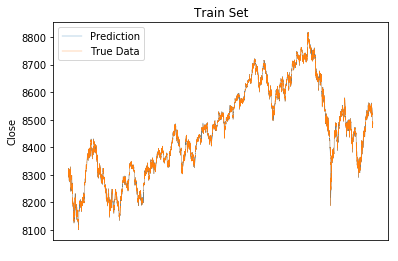

In [44]:
plt.plot(np.arange(len(Y_train_rnn)), predict_train_rnn, label='Prediction', linewidth=0.3)
plt.plot(np.arange(len(Y_train_rnn)), Y_train_rnn, label='True Data', linewidth=0.3)
plt.xlabel(' ')
plt.xticks([])
plt.ylabel('Close')
plt.title('Train Set')
plt.legend()
plt.show()

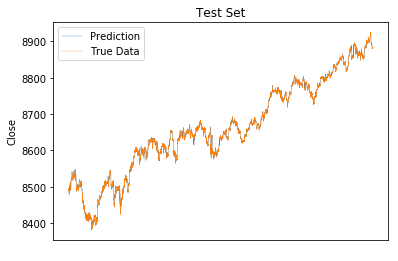

In [45]:
plt.plot(np.arange(len(Y_predict_rnn)), predict_test_rnn, label='Prediction', linewidth=0.3)
plt.plot(np.arange(len(Y_predict_rnn)), Y_predict_rnn, label='True Data', linewidth=0.3)
plt.xlabel(' ')
plt.xticks([])
plt.ylabel('Close')
plt.title('Test Set')
plt.legend()
plt.show()

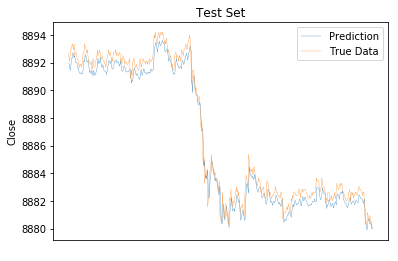

In [46]:
plt.plot(np.arange(len(Y_predict_rnn[-500:])), predict_test_rnn[-500:], label='Prediction', linewidth=0.3)
plt.plot(np.arange(len(Y_predict_rnn[-500:])), Y_predict_rnn[-500:], label='True Data', linewidth=0.3)
plt.xlabel(' ')
plt.xticks([])
plt.ylabel('Close')
plt.title('Test Set')
plt.legend()
plt.show()

## LSTM

In [17]:
model = buildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(5, input_shape=(5, 19))`
  after removing the cwd from sys.path.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5)                 500       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 506
Trainable params: 506
Non-trainable params: 0
_________________________________________________________________
Train on 327231 samples, validate on 46747 samples
Epoch 1/1000
327231/327231 [==============================] - 24s 72us/step - loss: 1.4771e-04 - val_loss: 5.8128e-06
Epoch 2/1000
327231/327231 [==============================] - 25s 77us/step - loss: 2.6023e-06 - val_loss: 3.9167e-06
Epoch 3/1000
327231/327231 [==============================] - 25s 77us/step - loss: 1.9065e-06 - val_loss: 4.0450e-06
Epoch 4/1000
327231/327231 [==============================] - 24s 74us/step - loss: 1.7586e-06 - val_loss: 3.8687e-06
Epoch 5/1000
3272

In [18]:
predict_train = model.predict(X_train)
predict_test = model.predict(X_predict)

In [19]:
predict_test_lstm = unnormalize(predict_test, close_mean, close_std)
predict_train_lstm = unnormalize(predict_train, close_mean, close_std)
Y_train_lstm = unnormalize(Y_train, close_mean, close_std)
Y_predict_lstm = unnormalize(Y_predict, close_mean, close_std)

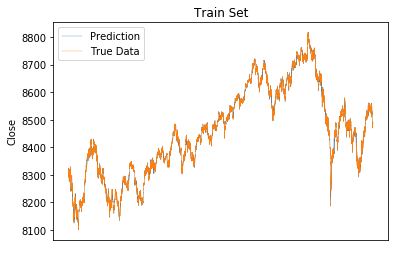

In [23]:
plt.plot(np.arange(len(Y_train_lstm)), predict_train_lstm, label='Prediction', linewidth=0.3)
plt.plot(np.arange(len(Y_train_lstm)), Y_train_lstm, label='True Data', linewidth=0.3)
plt.xlabel(' ')
plt.xticks([])
plt.ylabel('Close')
plt.title('Train Set')
plt.legend()
plt.show()

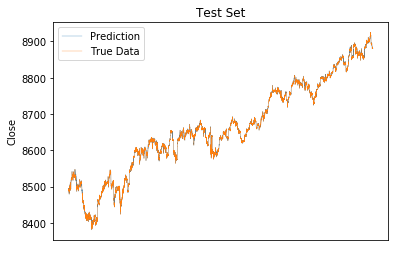

In [24]:
plt.plot(np.arange(len(Y_predict_lstm)), predict_test_lstm, label='Prediction', linewidth=0.3)
plt.plot(np.arange(len(Y_predict_lstm)), Y_predict_lstm, label='True Data', linewidth=0.3)
plt.xlabel(' ')
plt.xticks([])
plt.ylabel('Close')
plt.title('Test Set')
plt.legend()
plt.show()

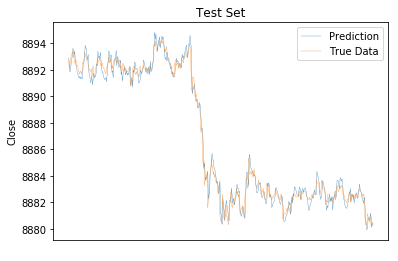

In [27]:
plt.plot(np.arange(len(Y_predict[-500:])), predict_test[-500:], label='Prediction', linewidth=0.3)
plt.plot(np.arange(len(Y_predict[-500:])), Y_predict[-500:], label='True Data', linewidth=0.3)
plt.xlabel(' ')
plt.xticks([])
plt.ylabel('Close')
plt.title('Test Set')
plt.legend()
plt.show()

In [1]:
df.iloc[0]

NameError: name 'df' is not defined